# Rice leaf Prediction 

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math 
import datetime
import time

# Using splitfolders to divide the data to train,validation and test.

In [2]:
import splitfolders
splitfolders.ratio("Data1", output="output4", seed=68, ratio=(0.8, 0.2, 0.0), group_prefix=None) # default values

Copying files: 119 files [00:00, 337.73 files/s]


In [28]:
#Default dimensions we found online
img_width, img_height = 150,150
#Create a bottleneck file
top_model_weights_path = "bottleneck_fc_model.h5"
# loading up our datasets
train_data_dir = "output4/train" 
validation_data_dir = "output4/val" 
test_data_dir = "output4/test"
 
# number of epochs to train top model 
epochs = 7 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

# Transfer learning

In [29]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights="imagenet")
datagen = ImageDataGenerator(rescale=1. / 255) 


# need to create the bottleneck .npy files for train,validate and test

In [30]:
#training data
start = datetime.datetime.now()
# getting data from directory and resizing the images.
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(150,150), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

bottleneck_features_train = vgg16.predict(generator, predict_size_train) 
 
np.save("bottleneck_features_train.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Found 95 images belonging to 3 classes.
Time:  0:00:12.877188


In [31]:
#validation data
start = datetime.datetime.now()
# getting data from directory and resizing the images.
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(150,150), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_val_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_val = int(math.ceil(nb_val_samples / batch_size)) 
 
bottleneck_features_val = vgg16.predict(generator, predict_size_val) 
 
np.save("bottleneck_features_val.npy", bottleneck_features_val)
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Found 23 images belonging to 3 classes.
Time:  0:00:03.433715


In [32]:
#test data
start = datetime.datetime.now()
# getting data from directory and resizing the images.
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(150,150), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_features_test = vgg16.predict(generator, predict_size_test) 
 
np.save("bottleneck_features_test.npy", bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Found 3 images belonging to 3 classes.
Time:  0:00:00.416381


# Adding the data to train,test and validate

In [33]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode="categorical", 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load("bottleneck_features_train.npy") 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 95 images belonging to 3 classes.


In [34]:
#validation data
generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(150,150), 
   batch_size=batch_size, 
   class_mode="categorical", 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load("bottleneck_features_val.npy") 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 23 images belonging to 3 classes.


In [35]:
#test data
generator_top = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(150,150), 
   batch_size=batch_size, 
   class_mode="categorical", 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load("bottleneck_features_test.npy") 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 3 images belonging to 3 classes.


In [36]:
# finding the size of data.
print('Training data shape : ', train_data.shape, train_labels.shape)

print('Testing data shape : ', validation_data.shape, validation_labels.shape)

Training data shape :  (95, 4, 4, 512) (95, 3)
Testing data shape :  (23, 4, 4, 512) (23, 3)


# Building the model

In [38]:
tart = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(64, activation="relu")) 
model.add(Dropout(0.5)) 
model.add(Dense(64, activation="sigmoid")) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation="softmax"))
model.compile(loss="categorical_crossentropy",
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=["acc"])


In [39]:
history = model.fit(train_data, train_labels, 
   epochs=30,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))


Epoch 1/30
2/2 [==============================] - 1s 237ms/step - loss: 1.4342 - acc: 0.2968 - val_loss: 1.1438 - val_acc: 0.3478
Epoch 2/30
2/2 [==============================] - 0s 64ms/step - loss: 1.1703 - acc: 0.2895 - val_loss: 1.0881 - val_acc: 0.3478
Epoch 3/30
2/2 [==============================] - 0s 52ms/step - loss: 1.1353 - acc: 0.3937 - val_loss: 1.0676 - val_acc: 0.3478
Epoch 4/30
2/2 [==============================] - 0s 52ms/step - loss: 1.1504 - acc: 0.3456 - val_loss: 1.0539 - val_acc: 0.3478
Epoch 5/30
2/2 [==============================] - 0s 49ms/step - loss: 1.1338 - acc: 0.3930 - val_loss: 1.0434 - val_acc: 0.3913
Epoch 6/30
2/2 [==============================] - 0s 45ms/step - loss: 1.1079 - acc: 0.3930 - val_loss: 1.0321 - val_acc: 0.5217
Epoch 7/30
2/2 [==============================] - 0s 60ms/step - loss: 1.1095 - acc: 0.4004 - val_loss: 1.0231 - val_acc: 0.5217
Epoch 8/30
2/2 [==============================] - 0s 60ms/step - loss: 1.1314 - acc: 0.4000 - va

# Evaluating the model

In [40]:
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size,     verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

1/1 [==============================] - 0s 16ms/step - loss: 0.8542 - acc: 0.7391
[INFO] accuracy: 73.91%
[INFO] Loss: 0.8541516661643982
Time:  0:00:04.303544


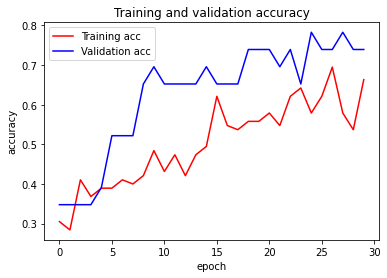

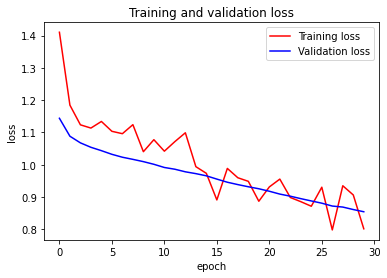

In [41]:
#Graphing our training and validation
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.ylabel("accuracy") 
plt.xlabel("epoch")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.ylabel("loss") 
plt.xlabel("epoch")
plt.legend()
plt.show()

In [42]:
model.evaluate(test_data,test_labels)

1/1 [==============================] - 0s 24ms/step - loss: 0.8480 - acc: 0.6667


[0.8480237126350403, 0.6666666865348816]

# The conclusion we got from this dataset is
# Training Accuracy=73.91%
# Testing Accuracy = 66.66%